In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from TX import upf
import subprocess
import os
from TX import bcc_rolling_fiber
vector_ang=bcc_rolling_fiber.vector_ang

     pf_for_lib is not available in the system
** joblib was not found - will not be used in TX.upf


## single point

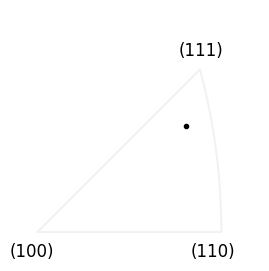

In [3]:
mypf=upf.polefigure(grains=[[0,35,30,1]],csym='cubic')
d=mypf.ipf(pole=[1,0,0],color='k',marker='.')

## calculate the arc of great circles between two crystal "plane normals"

In [4]:
!gfortran -c crystal_vectors.f -o crystal_vectors.o
!gfortran -c lib7.f -o lib7.o

In [5]:
dir_evpsc_repo='/Users/youngung/repo/evpsc/'
objfs=['chg_basis.o','voigt.o','fake_xit.o','data_crystal_fe.o',
       'funcs.o','lu_libs.o','lib_write.o','crystal_symmetry.o',
       'thermo_emod_cte.o','sx_version_tester.o']
# append the location
for i, o in enumerate(objfs): objfs[i]=os.path.join(dir_evpsc_repo,'objdir',o)
for i, o in enumerate(objfs):
    print(os.path.isfile(o))
#    
comp_cmd='gfortran crystal_vectors.o lib7.f'
for i, o in enumerate(objfs):
    comp_cmd=f'{comp_cmd} {o}'
comp_cmd=f'{comp_cmd} -o calc_cv'
print(f'comp_comd: {comp_cmd}')
p=subprocess.Popen(comp_cmd.split(),stdout=subprocess.PIPE,stderr=subprocess.PIPE)
stdo,stde=p.communicate()
print(stdo.decode())
print(stde.decode())

True
True
True
True
True
True
True
True
True
True
comp_comd: gfortran crystal_vectors.o lib7.f /Users/youngung/repo/evpsc/objdir/chg_basis.o /Users/youngung/repo/evpsc/objdir/voigt.o /Users/youngung/repo/evpsc/objdir/fake_xit.o /Users/youngung/repo/evpsc/objdir/data_crystal_fe.o /Users/youngung/repo/evpsc/objdir/funcs.o /Users/youngung/repo/evpsc/objdir/lu_libs.o /Users/youngung/repo/evpsc/objdir/lib_write.o /Users/youngung/repo/evpsc/objdir/crystal_symmetry.o /Users/youngung/repo/evpsc/objdir/thermo_emod_cte.o /Users/youngung/repo/evpsc/objdir/sx_version_tester.o -o calc_cv




In [6]:
ls ~/repo/evpsc/matData/vpscData/AA_jinhwa/sx_Al6061_affine.sx

/Users/youngung/repo/evpsc/matData/vpscData/AA_jinhwa/sx_Al6061_affine.sx


In [7]:
!./calc_cv ~/repo/evpsc/matData/vpscData/AA_jinhwa/sx_Al6061_affine.sx 1 1 1 1 1 0

  0.57735026918962573       0.57735026918962784       0.57735026918962373     
  0.70710678118654624       0.70710678118654868        0.0000000000000000     
 npoles:           0
 npoles:           0


In [8]:
def calc_cvec(miller,fnsx):
    """
    Get a crystal vector of a Miller-indexed plane normal
    """
    cmd=f'./calc_cv {fnsx}'
    for i, ind in enumerate(miller): cmd=f'{cmd} {ind}'
    cmd=f'{cmd}  '
    #print(f'cmd: {cmd}')
    p=subprocess.Popen(cmd.split(),stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    stdo,stde=p.communicate()
    #print(f'\n\n** stdo: {stdo.decode()}')
    return np.array(stdo.decode().split('\n')[0].split(),dtype='float')

def proj(a):
    #print(f'a.shape:, {a.shape}')
    if len(a.shape)>1:
        vs=a.copy()
    elif len(a.shape)==1:
        vs=np.zeros((1,3))
        vs[0,:]=a[::]
    nvec=vs.shape[0]
    coords=np.zeros((nvec,2))
    for i, v in enumerate(vs):
        coords[i,:]=upf.projection(v,[[0.,0.,0.,1]])
    return coords            

def circ():
    ths=np.linspace(-pi,pi)
    x=cos(ths);   y=sin(ths)
    return x,y

In [9]:
def calc_vref_and_rot(a,b,fnsx,nang):
    """
    Given a miller-indexed crystal plane normal (a and b),
    calclulate the v ref and rotation matrices vref.
    """
    aca=-calc_cvec(a,fnsx)
    bca=-calc_cvec(b,fnsx)
    ## reference vector
    vref=np.cross(aca,bca)
    #print(f'vref: {vref}')
    #print(f'aca: {aca}')

    ##
    thf=np.arccos(np.dot(aca,bca))
    #print(f'thf: {np.rad2deg(thf)}')
    ths=np.linspace(0,thf,nang)
    rots=np.zeros((nang,3,3))
    varc=np.zeros((nang,3))
    
    for i, th in enumerate(ths):
        rots[i,:,:]=vector_ang(vref,np.rad2deg(th))
    return aca, bca, thf, vref, rots
    
    
def calc_arc(aca,rots):#a,b,fnsx,nang):
    """
    Arguments
    ---------
    aca crystal direction
    """

    #aca, bca, thf, verf, rot = calc_vref_and_rot(a,b,fnsx,nang)
    nang=rots.shape[0]
    varc=np.zeros((nang,3))
    for i,rot in enumerate(rots):
        varc[i,:]=np.dot(rot,aca)
        
    return varc


In [10]:
def get_ipf_boundary(
    a=[0,0,1],b=[1,0,1],c=[1,1,1],
    fnsx='/Users/youngung/repo/evpsc/matData/vpscData/AA_jinhwa/sx_Al6061_affine.sx'):
    
    nres=100
    pairs=[[a,b],[b,c],[c,a]]
    coords=np.zeros((2,(nres-1)*3+1))

    

    
    for i, pair in enumerate(pairs[:3]):
        #varc,vref=calc_arc(*pair,fnsx,nres)
        #print(varc.shape)
        aca,bca,thf,vref,rots=calc_vref_and_rot(*pair,fnsx,nres)
        varc=calc_arc(aca,rots)
        xy=proj(varc)
        i0=i*(nres-1)
        i1=i0+nres-1
        print(f'i0,i1, {i0,i1}')
        coords[:,i0:i1]=xy[0:-1,:].T
    coords[:,-1]=coords[:,0]
    return coords


i0,i1, (0, 99)
i0,i1, (99, 198)
i0,i1, (198, 297)


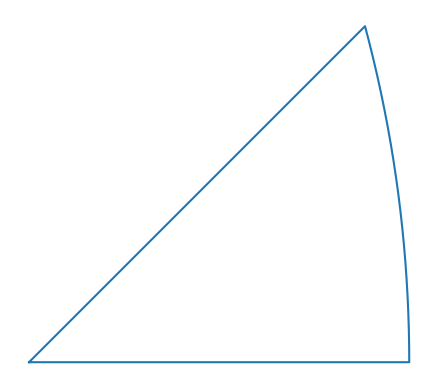

In [11]:
a=[0,0,1]
b=[1,0,1]
c=[1,1,1]
kw=dict(a=a,b=b,c=c,fnsx='/Users/youngung/repo/evpsc/matData/vpscData/AA_jinhwa/sx_Al6061_affine.sx')

## inverse pole figure boundaries
boundary=get_ipf_boundary(**kw)
fig=plt.figure();ax=fig.add_subplot(111)
ax.plot(boundary[0],boundary[1],'-')
## Find arcs between a and b vectors


ax.set_aspect('equal')
ax.set_axis_off()


i0,i1, (0, 99)
i0,i1, (99, 198)
i0,i1, (198, 297)


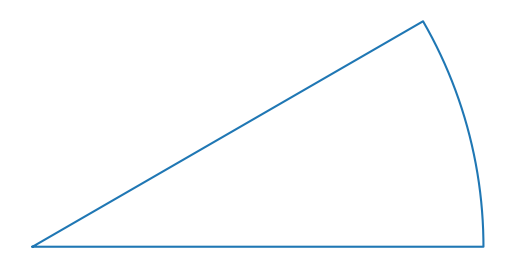

In [12]:
c=get_ipf_boundary(
    fnsx='/Users/youngung/repo/evpsc/matData/vpscData/CP-Ti-ICN/dd_015.sx',
    a=[0,0,0,1],
    b=[1,0,-1,0],
    c=[2,-1,-1,0])
fig=plt.figure();ax=fig.add_subplot(111)
ax.plot(c[0],c[1],'-')
ax.set_aspect('equal')
ax.set_axis_off()